Copyright 2018 Google LLC
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [3]:
import matplotlib.pyplot as plt
import math

# Memory Footprint and Overheads

General-purpose C++ hash tables get used in a lot of contexts. It's common for there to be many empty or singleton (size equal 1) instances, and it is also common for large tables to account for a substantial fraction of a system's memory. Overheads vary by algorithm and by contained value type. Further complicating matters there is variation in the transient overhead and internal fragmentation of the system memory allocator can absorb or amplify overheads. This notebook is an attempt to distill most of the complexity.

We'll focus mainly on average relative memory efficiency. Relative memory efficiency is just the number of bytes used by the hash table instance divided by the bytes devoted to contained values (`sizeof(value_type) * hash_table.size`). Average relative memory efficiency means that we'll perform some aggregation across all of the load factors that we might encounter in real life. To separate out the per-instance overheads from the per-element ones we'll compute average relative memory efficiency assuming that the per-instance overheads amortize to zero, then separately report the bytes used by an empty table and a singleton table. Average relative memory efficiency of 1 (or 100%) is ideal.

## Components

The memory footprint of most hash table algorithms can be broken down into three components: per-instance, per-rehash, and per-insert. Let's use libstdc++'s std::unordered_set as an example. This is a node-based chaining hash table. On x86_64 `sizeof(std::unordered_set) == 56`, so the per-instance footprint is 56 bytes. The per-instance footprint is the nodes that make up the bucket chain. They form a singly-linked list of value_type, so their footprint is `(sizeof(value_type) + 8) * hash_table.size()`. (For some types the hash code is cached in the node, but we'll ignore that for now.) The main hash array holds pointers, so the per-rehash allocation is `8 * hash_table.bucket_count()`.  Given these components, what should we expect for the memory overhead of a randomly chosen hash table in a running process?

## Averaging Across Load Factors

The per-rehash overheads are the trickiest to account for, because they vary based on the actual load factor of the table.  We can give minimum and maximum bounds for the memory footprint (from just after rehash, when the load factor is 1/2, and just before, when it is 1), but it would also be nice to give a single expected value.  One way to compute this is to assume that Benford's Law holds for the hash table sizes we actually find in real life.

Benford's Law says that if we pick a random table, the ratio of the probabilities that it is size n_1 or n_2 is n_2/n_1. Assuming a doubling rehash interval and moving to the continuous space lets us derive the same relationship for load factors, which means we can weight memory footprints by 1/lf over a range from 0.5 to 1 to compute the average footprint. The relative memory overhead of the per-rehash component above is `8 * hash_table.bucket_count() / (sizeof(value_type) * hash_table.size())` or `8/sizeof(value_type)`/lf. The weighted average gives `8/sizeof(value_type)` * ln 2. In general, the average of C/lf will be C ln 2 under the Benford Law assumption. For algorithms like `google::dense_hash_set` that don't have a maximum load factor of 1, we use ratio of the current load factor to the maximum load factor so that it still ranges from 0.5 to 1. We'll also use the same ratio for tables that use prime bucket counts, because they converge on doubling as the size gets large.

## Extracting sizeof(value_type) and sizeof(void*)

We further observe that in practice each of the 3 components can be written as `A * sizeof(value_type) + B * sizeof(void*) + C` (ignoring alignment constraints). In the python code below we'll put these in a 3-tuple `(A,B,C)`. For the per-rehash memory footprint we'll express them per-element at the maximum load factor before rehash. In the `std::unordered_set` example this will be an overhead of 1 pointer per element.

## Accounting for Internal Fragmentation in malloc

tcmalloc, jemalloc, and other high-performance general-purpose memory allocators break allocations into size classes, accepting memory waste to limit long-running fragmentation. malloc_usable_size can be used to determine the actual number of bytes reserved as part of an allocation. This means, for example, that the actual memory used by 32 calls to `malloc(1)` is much more than 32 bytes. In order to be able to model this, we'll write down memory overheads not as 3-tuples (with `sizeof(value_type)`, `sizeof(void*)`, and constant factors) but as a list of overheads each of which constitutes one actual allocation.

## A complex case for F14Vector with reserve()

F14Vector has the ability to exactly size the value_type allocation when it is given a capacity via an explicit reserve. In this case the main hash table will be sized with a power of two but the value_type storage will be undersized. Further complicating matters is that the two arrays are part of a single heap allocation, and that allocation is subject to internal fragmentation. An analytic solution to the exact overheads in this case is overkill; instead we compute overheads for all sizes from 1025 to 2048 (inclusive) and weight each overhead by 1/size. This technique gives matching results for the simple case as well.

In [73]:
# Per-instance, per-rehash, and per-insert memory footprint components, the
# footprint of an empty table in addition to the per-instance footprint, and
# the footprint of a table with a single element in addition to the per-instance
# footprint.  Tables that lazily allocate their dynamic memory should have
# "empty": []
#
# Each footprint is a list of allocations, with the size of the allocation given
# as a 3-tuple F that indicates that the allocation is of size
# F[0]*sizeof(value_type) + F[1]*sizeof(void*) + F[2].
# Per-rehash component is per-element at maximum load factor, Benford scaling
# will be applied.  "rehash" component has an optional 4th, 5th, and 6th
# element that describes the per-element load that is not subject to Benford
# scaling (applicable only under perfect reserve() or initialCapacity).
mem_components = [
    {
        "name": "libstdc++ std::unordered_set",
        "instance": [(0, 7, 0)],
        "rehash": [(0, 1, 0)],
        "insert": [(1, 1, 0)],
        "empty": [],
        "singleton": [(0, 2, 0), (1, 1, 0)], # initial bucket_count == 2, plus 1 node
        "linestyle": ":",
    },
    {
        # libstdc++ caches the hash code for std::string, long double, and hash
        # functors whose operator() is not marked noexcept
        "name": "libstdc++ std::unordered_set w/ cached hash",
        "instance": [(0, 7, 0)],
        "rehash": [(0, 1, 0)],
        "insert": [(1, 2, 0)],
        "empty": [],
        "singleton": [(0, 2, 0), (1, 2, 0)],
        "linestyle": ":",
    },
    # TODO __gnu_cxx::hash_set
    {
        "name": "google::dense_hash_set",
        "instance": [(2, 7, 8)],
        "rehash": [(2, 0, 0)],
        "insert": [],
        "empty": [(32, 0, 0)], # initial bucket count is 32, not lazy
        "singleton": [(32, 0, 0)],
        "linestyle": "-",
    },
    {
        "name": "absl::flat_hash_set",
        "instance": [(0, 5, 0)],
        "rehash": [(8.0/7, 0, 8.0/7)],
        "insert": [],
        "empty": [],
        "singleton": [(15, 0, 32)],
        "linestyle": "-",
    },
    {
        "name": "absl::node_hash_set",
        "instance": [(0, 5, 0)],
        "rehash": [(0, 8.0/7, 8.0/7)],
        "insert": [(1, 0, 0)],
        "empty": [],
        "singleton": [(1, 15, 32)],
        "linestyle": ":",
    },
    {
        "name": "folly::F14ValueSet",
        "instance": [(0, 4, 0)],
        "rehash": [(14.0/12, 0, 16.0/12)],
        "insert": [],
        "empty": [],
        "singleton": [(2, 0, 16)], # fractional chunk holds 2 values
        "linestyle": "-",
    },
    {
        "name": "folly::F14NodeSet",
        "instance": [(0, 4, 0)],
        "rehash": [(0, 14.0/12, 16.0/12)],
        "insert": [(1, 0, 0)],
        "empty": [],
        "singleton": [(1, 2, 16)], # fractional chunk holds 2 values
        "linestyle": ":",
    },
    {
        "name": "folly::F14VectorSet",
        "instance": [(0, 2, 8)],
        "rehash": [(1, 0, 64.0/10)],
        "insert": [],
        "empty": [],
        "singleton": [(2, 0, 24)],
        "linestyle": "--",
    },
    {
        "name": "reserved folly::F14VectorSet",
        "instance": [(0, 2, 8)],
        "rehash": [(0, 0, 64.0/10, 1, 0, 0)],
        "insert": [],
        "empty": [],
        "singleton": [(1, 0, 24)], # (1, 0, 20) if value_type has 4-byte alignment
        "linestyle": "--",
    },
    {
        "name": "ska::flat_hash_set",
        "instance": [(0, 4, 0)],
        "rehash": [(2, 2, 0)],
        "insert": [],
        "empty": [],
        "singleton": [(8, 8, 0)], # initial capacity 4
        "linestyle": "-",
    },
    {
        "name": "ska::bytell_hash_set",
        "instance": [(0, 4, 0)],
        "rehash": [(1/0.9, 0, 1/0.9)], # max LF is 0.9375, but early rehash makes the effective max LF lower
        "insert": [],
        "empty": [],
        "singleton": [(16, 0, 16)], # initial capacity 10/0.9375 -> 11 -> 16
        "linestyle": "-",
    },
]

def tally(f, p):
    return (sum([e[0] for e in f] + [0]), sum([e[1] * p + e[2] for e in f] + [0]))

def jemalloc_size_class(req):
    # default jemalloc size classes are 8, 16, 32, 48, then 4, 5, 6, and 7 times powers of 2
    for m in [8, 16, 32, 48]:
        if req <= m:
            return m
    a = 16
    while True:
        for m in range(4, 8):
            if req <= m * a:
                return m * a
        a *= 2
        
def tcmalloc_size_class(req):
    # default tcmalloc is spaced twice as closely as jemalloc
    a = 16
    while a < req:
        step = max(16, min(8192, (1 << int(math.log(a) / math.log(2) + 1e-6)) / 8))
        a += step
    return a

def size_class(req):
    return jemalloc_size_class(req)
        
def benford_adjust(x, y):
    total = 0
    totalw = 0
    for n in range(1025, 2049):
        weight = 1.0 / n
        total += weight * size_class(2048 * x + y * n) / n
        totalw += weight
    return total / totalw

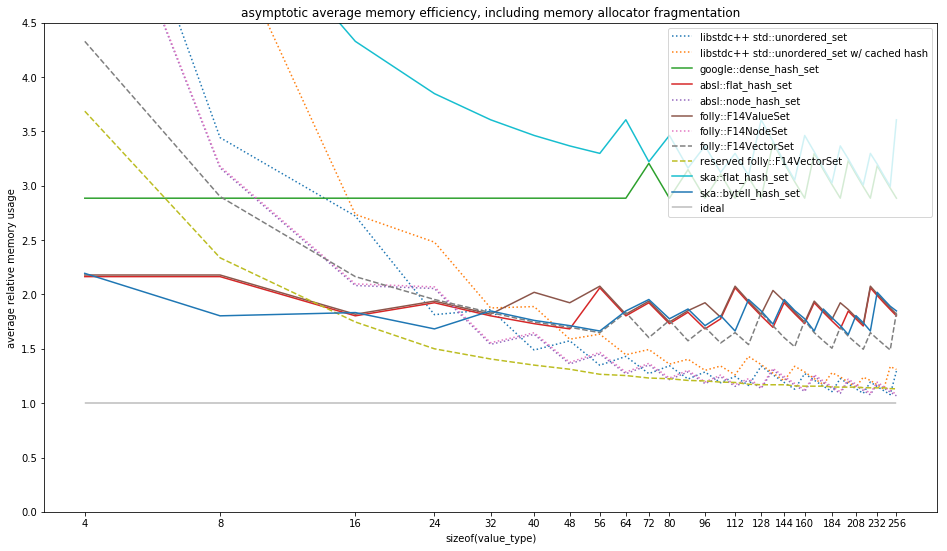

In [76]:
value_sizes = [4] + [i for i in range(8, 256+1, 8)]
xt = [4, 8]
for v in value_sizes:
    if v > xt[-1] * 1.10:
        xt.append(v)
plt.rcParams["figure.figsize"] = [16,9]
# scaling = 1 models just before rehash, scaling = 2 models just after
# scaling = 1 / math.log(2) models weighted average if sizes follow Benford's Law
scaling = 1 / math.log(2)
ylim = 4.5
non_overlap = ylim / 300
overlap_adjust = {}
for v in value_sizes:
    overlap_adjust[v] = {}
for m in mem_components:
    ys = []
    for v in value_sizes:
        a = 0
        for f in m["insert"]:
            a += size_class(f[0] * v + f[1] * 8 + f[2])
        for f in m["rehash"]:
            x = f[0] * v + f[1] * 8 + f[2]
            if len(f) >= 6:
                # complex case for partially-exact capacity in reserved F14Vector
                y = f[3] * v + f[4] * 8 + f[5]
                a += benford_adjust(x, y)
            else:
                # avoid small size classes by scaling, then multiply to account for Benford's Law
                a += size_class(x * 1024) / 1024.0 * scaling
                # same answer from brute-force computation
                #a += benford_adjust(x, 0)
        y = a / v
        ys.append(y + overlap_adjust[v].get(y, 0))
        overlap_adjust[v][y] = overlap_adjust[v].get(y, 0) + non_overlap
    plt.plot(value_sizes, ys, label=m["name"], linestyle=m["linestyle"])
plt.plot(value_sizes, [1.0 for y in value_sizes], label="ideal", color='black', linewidth=0.4)
plt.ylim((0, ylim))
plt.xscale('log')
plt.legend(loc='upper right')
plt.xlabel('sizeof(value_type)')
plt.xticks(xt, xt)
plt.minorticks_off()
plt.ylabel('average relative memory usage')
plt.title('asymptotic average memory efficiency, including memory allocator fragmentation')
plt.show()
#plt.savefig('hashtable_mem_efficiency_jemalloc.pdf')

In [55]:
print("Single-element table footprint, 64-bit platforms, ignoring memory allocator fragmentation")
print("")
for m in mem_components:
    f = tally(m["instance"] + m["singleton"], 8)
    print("%32s ->  %2d + %d * sizeof(value_type)" % (m["name"], f[1], f[0]))

Single-element table footprint, 64-bit platforms, ignoring memory allocator fragmentation

    libstdc++ std::unordered_set ->  80 + 1 * sizeof(value_type)
          google::dense_hash_set ->  64 + 34 * sizeof(value_type)
             absl::flat_hash_set ->  72 + 15 * sizeof(value_type)
             absl::node_hash_set ->  192 + 1 * sizeof(value_type)
              folly::F14ValueSet ->  48 + 2 * sizeof(value_type)
               folly::F14NodeSet ->  64 + 1 * sizeof(value_type)
             folly::F14VectorSet ->  48 + 2 * sizeof(value_type)
    reserved folly::F14VectorSet ->  48 + 1 * sizeof(value_type)
              ska::flat_hash_set ->  96 + 8 * sizeof(value_type)
            ska::bytell_hash_set ->  48 + 16 * sizeof(value_type)


In [54]:
print("Empty table footprint, 64-bit platforms, ignoring memory allocator fragmentation")
print("")
for m in mem_components:
    f = tally(m["instance"] + m["empty"], 8)
    print("%32s ->  %2d + %d * sizeof(value_type)" % (m["name"], f[1], f[0]))

Empty table footprint, 64-bit platforms, ignoring memory allocator fragmentation

    libstdc++ std::unordered_set ->  56 + 0 * sizeof(value_type)
          google::dense_hash_set ->  64 + 34 * sizeof(value_type)
             absl::flat_hash_set ->  40 + 0 * sizeof(value_type)
             absl::node_hash_set ->  40 + 0 * sizeof(value_type)
              folly::F14ValueSet ->  32 + 0 * sizeof(value_type)
               folly::F14NodeSet ->  32 + 0 * sizeof(value_type)
             folly::F14VectorSet ->  24 + 0 * sizeof(value_type)
    reserved folly::F14VectorSet ->  24 + 0 * sizeof(value_type)
              ska::flat_hash_set ->  32 + 0 * sizeof(value_type)
            ska::bytell_hash_set ->  32 + 0 * sizeof(value_type)
